# import files

In [ ]:
import os
from google.colab import files
import pandas as pd
import numpy as np
import string
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


# inpoot banfake dataset


In [ ]:
# Upload kaggle.json if needed
if not os.path.exists('kaggle.json'):
    print("Please upload your kaggle.json file:")
    uploaded = files.upload()
else:
    print("kaggle.json already exists. Skipping upload.")

# Install packages
!pip install -q kaggle xgboost lightgbm imbalanced-learn

# Kaggle CLI setup
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download and unzip dataset
!kaggle datasets download -d hrithikmajumdar/bangla-fake-news
!unzip -o bangla-fake-news.zip -d ./banfake-news

!ls ./banfake-news/

kaggle.json already exists. Skipping upload.
Dataset URL: https://www.kaggle.com/datasets/hrithikmajumdar/bangla-fake-news
License(s): apache-2.0
bangla-fake-news.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  bangla-fake-news.zip
  inflating: ./banfake-news/test_cleaned.csv  
  inflating: ./banfake-news/train_cleaned.csv  
  inflating: ./banfake-news/val_cleaned.csv  
test_cleaned.csv  train_cleaned.csv  val_cleaned.csv


lode banfake dataset

In [ ]:
# Load datasets
train_df = pd.read_csv('/content/banfake-news/train_cleaned.csv')
test_df = pd.read_csv('/content/banfake-news/test_cleaned.csv')
validation_df = pd.read_csv('/content/banfake-news/val_cleaned.csv')

take Fake (0) -> 0, Real (3) -> 1

In [ ]:
label_column = 'Label'

# Combine all data
df_all = pd.concat([train_df, test_df, validation_df], ignore_index=True)

# Binary label mapping: Fake (0) -> 0, Real (3) -> 1
real_df = df_all[df_all['Label'] == 3].copy()
fake_df = df_all[df_all['Label'] == 0].copy()

real_df['Label'] = 1
fake_df['Label'] = 0

In [ ]:
real_df['text'] = real_df['Headline'].fillna('') + ' ' + real_df['Content'].fillna('')
real_df['text'] = real_df['text'].astype(str).str.lower().str.translate(str.maketrans('', '', string.punctuation))

fake_df['text'] = fake_df['Headline'].fillna('') + ' ' + fake_df['Content'].fillna('')
fake_df['text'] = fake_df['text'].astype(str).str.lower().str.translate(str.maketrans('', '', string.punctuation))

# lode bangla_fake500 dataset

In [ ]:
!kaggle datasets download -d zihadbappy/banglafakenews500
!mkdir -p ./bangla_fake500
!unzip -o banglafakenews500.zip -d ./bangla_fake500

# Install openpyxl
!pip install openpyxl

# Load Excel and clean
df500 = pd.read_excel('./bangla_fake500/BanglaFakeNews500.xlsx')
df500['text'] = df500['headline'].fillna('') + ' ' + df500['Content'].fillna('')
df500['text'] = df500['text'].astype(str).str.lower().str.translate(str.maketrans('', '', string.punctuation))
df500['label'] = 0

df500 = df500[['text', 'label']]

Dataset URL: https://www.kaggle.com/datasets/zihadbappy/banglafakenews500
License(s): CC0-1.0
banglafakenews500.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  banglafakenews500.zip
  inflating: ./bangla_fake500/BanglaFakeNews500.xlsx  


# marge buth dataset

In [ ]:
import pandas as pd
# Rename 'label' column in df500 to match 'Label' in fake_df
df500.rename(columns={'label': 'Label'}, inplace=True)

# Concatenate fake_df and df500
fake_df = pd.concat([fake_df, df500], ignore_index=True)

print(f"Number of fake news articles after adding df500: {len(fake_df)}")

Number of fake news articles after adding df500: 2682


/tmp/ipython-input-49-1932711138.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df500.rename(columns={'label': 'Label'}, inplace=True)


In [ ]:
if len(real_df) > 2682:
    real_df = real_df.sample(n=2682, random_state=42).reset_index(drop=True)

print(f"Final number of real news articles: {len(real_df)}")

Final number of real news articles: 2682


In [ ]:
import pandas as pd
# Concatenate real_df and fake_df into All_df
All_df = pd.concat([real_df, fake_df], ignore_index=True)

print(f"Total number of articles in All_df: {len(All_df)}")
print(All_df['Label'].value_counts())

Total number of articles in All_df: 5364
Label
1    2682
0    2682
Name: count, dtype: int64


In [ ]:
# prompt: show the dize of All_df

print(f"Size of All_df: {All_df.shape}")
All_df.head()

Size of All_df: (5364, 4)


,Headline,Content,Label,text
0,পলাতকরা কে কোথায়,ভয়াবহ ২১ আগস্ট গ্রেনেড হামলার মামলায় পলাতক ১৮ ...,1,পলাতকরা কে কোথায় ভয়াবহ ২১ আগস্ট গ্রেনেড হামলার...
1,ইসরাইলি বিমান হামলা সিরিয়ার সার্বভৌমত্বের লঙ্ঘ...,আন্তর্জাতিক ডেস্ক আরটিএনএন মস্কো: রাশিয়ার প্রে...,1,ইসরাইলি বিমান হামলা সিরিয়ার সার্বভৌমত্বের লঙ্ঘ...
2,"ঢাবিতে বিক্ষোভ সমাবেশ, আদিবাসী কোটা ৫ শতাংশ রা...",দ্য রিপোর্ট ডেস্ক : সরকারি চাকরিতে প্রথম ও দ্ব...,1,ঢাবিতে বিক্ষোভ সমাবেশ আদিবাসী কোটা ৫ শতাংশ রাখ...
3,এবারও সেরাদের সেরা রাজশাহীর মেয়েরা,বিতর্ক উৎসবে শ্রেষ্ঠত্ব অর্জন করল রাজশাহী শহরে...,1,এবারও সেরাদের সেরা রাজশাহীর মেয়েরা বিতর্ক উৎসব...
4,জাতীয় ঐক্য’র যৌথ নেতৃত্বে বদরুদ্দোজা-কামাল-ফখরুল,নিজস্ব প্রতিবেদক আরটিএনএন ঢাকা: জাতীয় ঐক্যকে এ...,1,জাতীয় ঐক্য’র যৌথ নেতৃত্বে বদরুদ্দোজাকামালফখরুল...


In [ ]:
import pandas as pd
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
tfidf_matrix = tfidf_vectorizer.fit_transform(All_df['text'])

tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

all_df = pd.concat([tfidf_df, All_df['Label']], axis=1)


In [ ]:
X = all_df.drop('Label', axis=1)
y = all_df['Label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

SVM Accuracy: 0.9002795899347623
SVM Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.89      0.90       537
           1       0.89      0.91      0.90       536

    accuracy                           0.90      1073
   macro avg       0.90      0.90      0.90      1073
weighted avg       0.90      0.90      0.90      1073



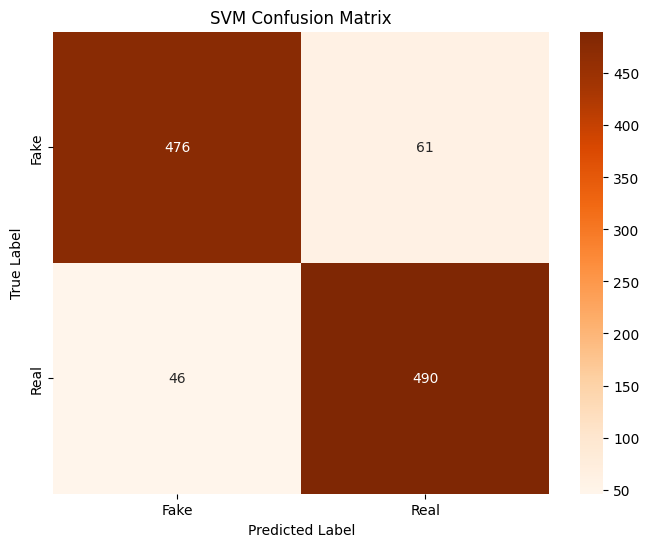

In [ ]:
# prompt: train SVM

import matplotlib.pyplot as plt
# Train a Linear SVM model
svm_model = LinearSVC(random_state=42)
svm_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_svm = svm_model.predict(X_test)

# Evaluate the model
accuracy_svm = accuracy_score(y_test, y_pred_svm)
report_svm = classification_report(y_test, y_pred_svm)
conf_matrix_svm = confusion_matrix(y_test, y_pred_svm)

print(f"SVM Accuracy: {accuracy_svm}")
print("SVM Classification Report:")
print(report_svm)


# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_svm, annot=True, fmt="d", cmap="Oranges", xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.title("SVM Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


Logistic Regression Model Evaluation:
Accuracy: 0.9040074557315937
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.89      0.90       537
           1       0.89      0.92      0.91       536

    accuracy                           0.90      1073
   macro avg       0.90      0.90      0.90      1073
weighted avg       0.90      0.90      0.90      1073



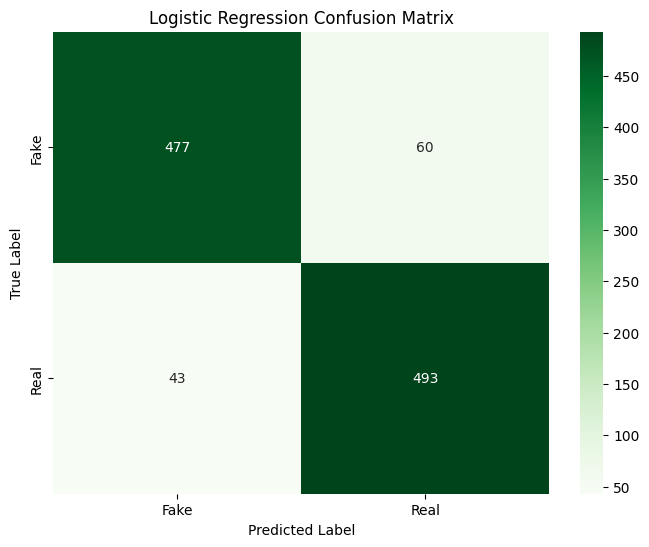

In [ ]:
# prompt: Train Logistic Regression

import matplotlib.pyplot as plt
# Train a Logistic Regression model
log_reg_model = LogisticRegression(random_state=42)
log_reg_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_log_reg = log_reg_model.predict(X_test)

# Evaluate the model
accuracy_log_reg = accuracy_score(y_test, y_pred_log_reg)
report_log_reg = classification_report(y_test, y_pred_log_reg)
conf_matrix_log_reg = confusion_matrix(y_test, y_pred_log_reg)

# Print evaluation metrics
print("\nLogistic Regression Model Evaluation:")
print(f"Accuracy: {accuracy_log_reg}")
print("Classification Report:")
print(report_log_reg)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_log_reg, annot=True, fmt="d", cmap="Greens", xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.title("Logistic Regression Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


Naive Bayes Model Evaluation:
Accuracy: 0.9114631873252563
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.89      0.91       537
           1       0.89      0.93      0.91       536

    accuracy                           0.91      1073
   macro avg       0.91      0.91      0.91      1073
weighted avg       0.91      0.91      0.91      1073



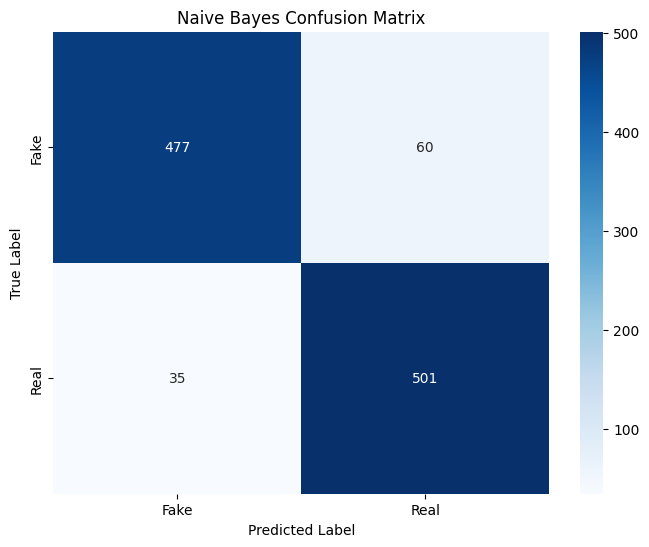

In [ ]:
# prompt: # Train Naive Bayes

import matplotlib.pyplot as plt
# Train a Naive Bayes model
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_nb = nb_model.predict(X_test)

# Evaluate the model
accuracy_nb = accuracy_score(y_test, y_pred_nb)
report_nb = classification_report(y_test, y_pred_nb)
conf_matrix_nb = confusion_matrix(y_test, y_pred_nb)

# Print evaluation metrics
print("\nNaive Bayes Model Evaluation:")
print(f"Accuracy: {accuracy_nb}")
print("Classification Report:")
print(report_nb)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_nb, annot=True, fmt="d", cmap="Blues", xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.title("Naive Bayes Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


XGBoost Model Evaluation:
Accuracy: 0.9095992544268406
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.90      0.91       537
           1       0.90      0.92      0.91       536

    accuracy                           0.91      1073
   macro avg       0.91      0.91      0.91      1073
weighted avg       0.91      0.91      0.91      1073



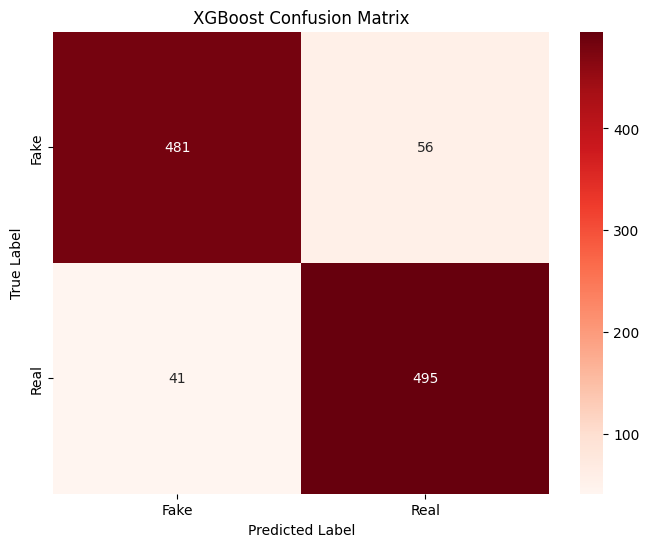

In [ ]:
# Train XGBoost

import matplotlib.pyplot as plt
# Train an XGBoost model
import xgboost as xgb

xgb_model = xgb.XGBClassifier(random_state=42)
xgb_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate the model
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
report_xgb = classification_report(y_test, y_pred_xgb)
conf_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)

# Print evaluation metrics
print("\nXGBoost Model Evaluation:")
print(f"Accuracy: {accuracy_xgb}")
print("Classification Report:")
print(report_xgb)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_xgb, annot=True, fmt="d", cmap="Reds", xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.title("XGBoost Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


[LightGBM] [Info] Number of positive: 2146, number of negative: 2145
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.150899 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 99750
[LightGBM] [Info] Number of data points in the train set: 4291, number of used features: 1650
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500117 -> initscore=0.000466
[LightGBM] [Info] Start training from score 0.000466

LightGBM Model Evaluation:
Accuracy: 0.9114631873252563
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.89      0.91       537
           1       0.89      0.93      0.91       536

    accuracy                           0.91      1073
   macro avg       0.91      0.91      0.91      1073
weighted avg       0.91      0.91      0.91      1073



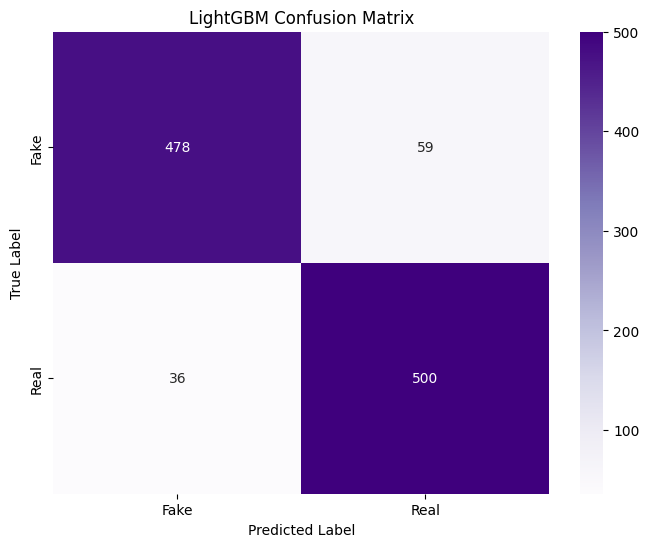

In [ ]:
# prompt: Train LightGBM

import matplotlib.pyplot as plt
import lightgbm as lgb

# Train a LightGBM model
lgb_model = lgb.LGBMClassifier(random_state=42)
lgb_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_lgb = lgb_model.predict(X_test)

# Evaluate the model
accuracy_lgb = accuracy_score(y_test, y_pred_lgb)
report_lgb = classification_report(y_test, y_pred_lgb)
conf_matrix_lgb = confusion_matrix(y_test, y_pred_lgb)

# Print evaluation metrics
print("\nLightGBM Model Evaluation:")
print(f"Accuracy: {accuracy_lgb}")
print("Classification Report:")
print(report_lgb)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_lgb, annot=True, fmt="d", cmap="Purples", xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.title("LightGBM Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

[LightGBM] [Info] Number of positive: 2146, number of negative: 2145
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.149923 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 99750
[LightGBM] [Info] Number of data points in the train set: 4291, number of used features: 1650
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500117 -> initscore=0.000466
[LightGBM] [Info] Start training from score 0.000466

Ensemble Model Evaluation:
Accuracy: 0.9133271202236719
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.90      0.91       537
           1       0.90      0.93      0.91       536

    accuracy                           0.91      1073
   macro avg       0.91      0.91      0.91      1073
weighted avg       0.91      0.91      0.91      1073



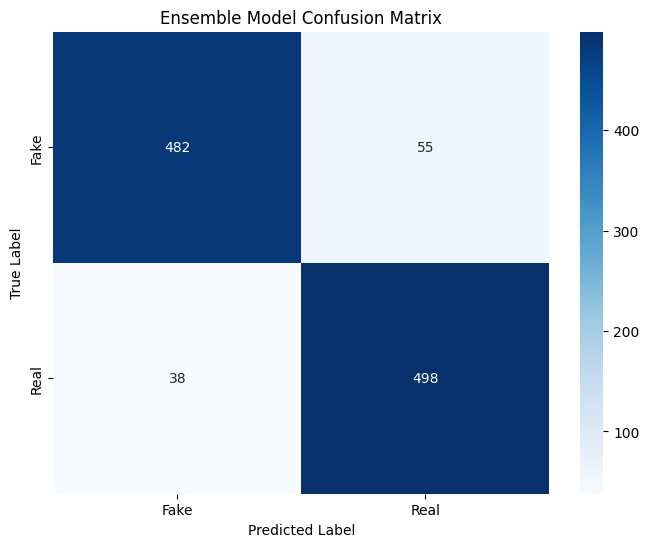

In [ ]:
# prompt: Ensemble with all 5 models

import matplotlib.pyplot as plt
# Create the ensemble model using VotingClassifier
ensemble_model = VotingClassifier(estimators=[
    ('svm', svm_model),
    ('log_reg', log_reg_model),
    ('nb', nb_model),
    ('xgb', xgb_model),
    ('lgb', lgb_model)
], voting='hard') # 'hard' for majority voting

# Train the ensemble model
ensemble_model.fit(X_train, y_train)

# Make predictions with the ensemble model
y_pred_ensemble = ensemble_model.predict(X_test)

# Evaluate the ensemble model
accuracy_ensemble = accuracy_score(y_test, y_pred_ensemble)
report_ensemble = classification_report(y_test, y_pred_ensemble)
conf_matrix_ensemble = confusion_matrix(y_test, y_pred_ensemble)

# Print evaluation metrics for the ensemble model
print("\nEnsemble Model Evaluation:")
print(f"Accuracy: {accuracy_ensemble}")
print("Classification Report:")
print(report_ensemble)

# Plot confusion matrix for the ensemble model
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_ensemble, annot=True, fmt="d", cmap="Blues", xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.title("Ensemble Model Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

[LightGBM] [Info] Number of positive: 2146, number of negative: 2145
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.155447 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 99750
[LightGBM] [Info] Number of data points in the train set: 4291, number of used features: 1650
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500117 -> initscore=0.000466
[LightGBM] [Info] Start training from score 0.000466

Top 3 Ensemble Model Evaluation (LightGBM, XGBoost, Naive Bayes):
Accuracy: 0.918918918918919
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.90      0.92       537
           1       0.90      0.94      0.92       536

    accuracy                           0.92      1073
   macro avg       0.92      0.92      0.92      1073
weighted avg       0.92      0.92      0.92      1073


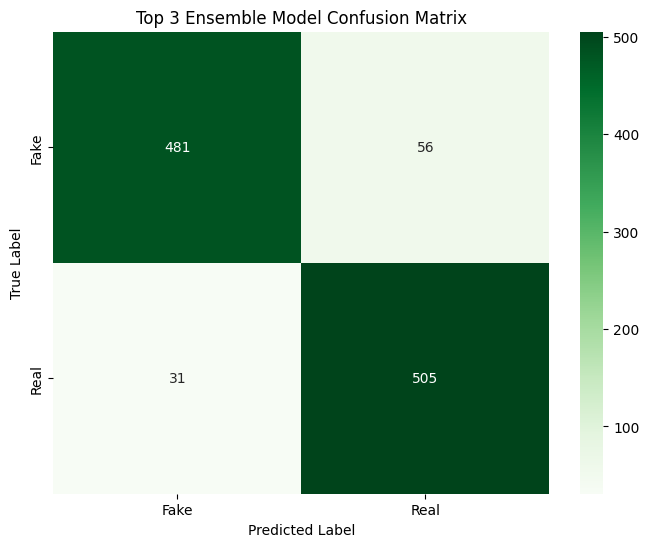

In [ ]:
# prompt: Ensemble with best 3 (assumed LightGBM, XGBoost, Naive Bayes)

import matplotlib.pyplot as plt
# Create the ensemble model using VotingClassifier with the top 3 models (assuming LightGBM, XGBoost, Naive Bayes from previous output/task description)
ensemble_model_top3 = VotingClassifier(estimators=[
    ('lgb', lgb_model),
    ('xgb', xgb_model),
    ('nb', nb_model)
], voting='hard') # 'hard' for majority voting

# Train the top 3 ensemble model
ensemble_model_top3.fit(X_train, y_train)

# Make predictions with the top 3 ensemble model
y_pred_ensemble_top3 = ensemble_model_top3.predict(X_test)

# Evaluate the top 3 ensemble model
accuracy_ensemble_top3 = accuracy_score(y_test, y_pred_ensemble_top3)
report_ensemble_top3 = classification_report(y_test, y_pred_ensemble_top3)
conf_matrix_ensemble_top3 = confusion_matrix(y_test, y_pred_ensemble_top3)

# Print evaluation metrics for the top 3 ensemble model
print("\nTop 3 Ensemble Model Evaluation (LightGBM, XGBoost, Naive Bayes):")
print(f"Accuracy: {accuracy_ensemble_top3}")
print("Classification Report:")
print(report_ensemble_top3)

# Plot confusion matrix for the top 3 ensemble model
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_ensemble_top3, annot=True, fmt="d", cmap="Greens", xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.title("Top 3 Ensemble Model Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 50s 383ms/step - accuracy: 0.6110 - loss: 0.6426 - val_accuracy: 0.8894 - val_loss: 0.3409
Epoch 2/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 78s 347ms/step - accuracy: 0.8779 - loss: 0.3602 - val_accuracy: 0.8778 - val_loss: 0.3646
Epoch 3/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 42s 360ms/step - accuracy: 0.9173 - loss: 0.2687 - val_accuracy: 0.8952 - val_loss: 0.3033
Epoch 4/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 39s 345ms/step - accuracy: 0.9339 - loss: 0.2257 - val_accuracy: 0.9057 - val_loss: 0.2937
Epoch 5/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 41s 345ms/step - accuracy: 0.7410 - loss: 0.4878 - val_accuracy: 0.5704 - val_loss: 0.6391
Epoch 6/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 39s 361ms/step - accuracy: 0.5430 - loss: 0.6562 - val_accuracy: 0.5681 - val_loss: 0.6372
Epoch 7/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 40s 354ms/step - accuracy: 0.5485 - loss: 0.6684 - val_accuracy: 0.5052 - val_loss: 0.6793
Epoch 8/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 43s 369ms/step - accuracy: 0.5299 - loss: 0

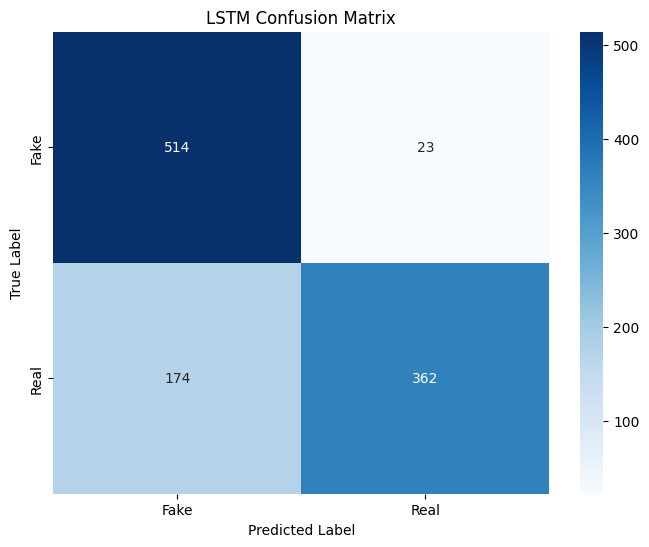

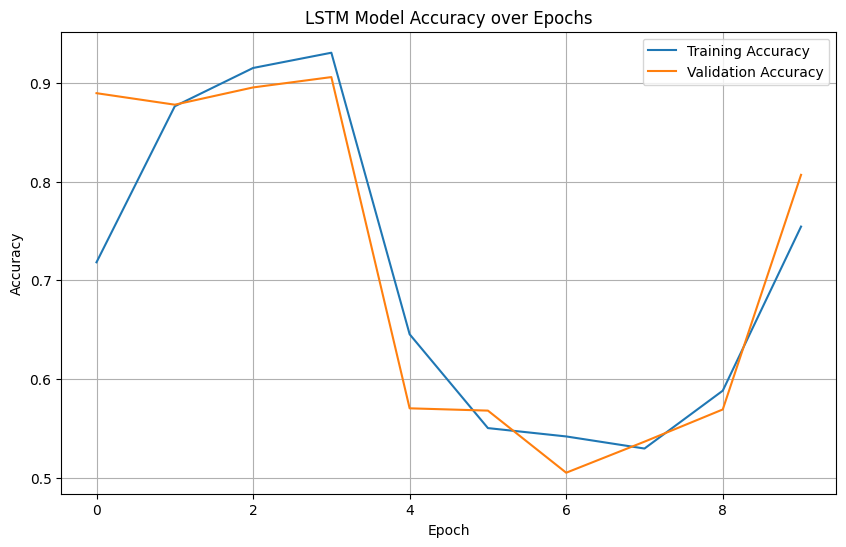

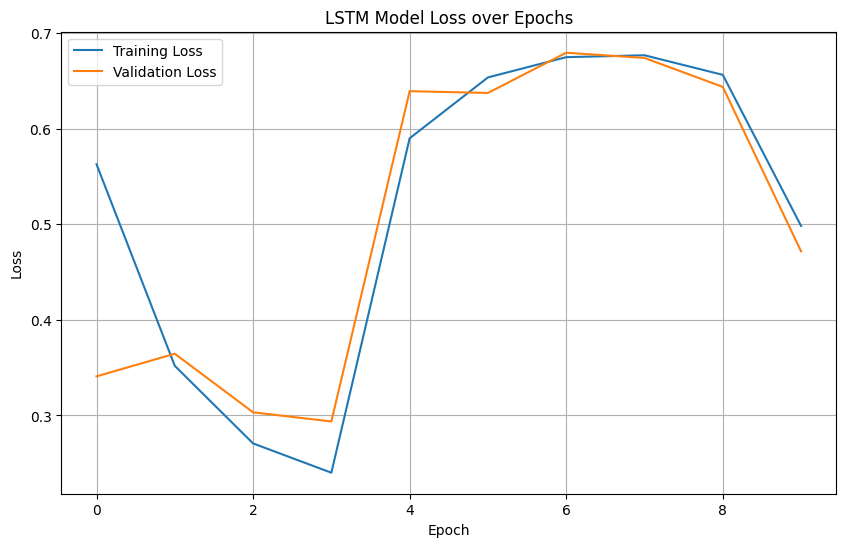

In [ ]:
# prompt: Create a complete Keras LSTM-based fake news detection model for Bangla text in Colab. Use Tokenizer and pad_sequences for text preprocessing, build a Sequential model with Embedding and LSTM layers, and evaluate it using accuracy. Assume the All_df  has 'text' and 'label' columns.

import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

# Assuming All_df is already loaded and contains 'text' and 'Label' columns
# Split data into training and testing sets
X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(All_df['text'], All_df['Label'], test_size=0.2, random_state=42, stratify=All_df['Label'])

# Define parameters for text processing
vocab_size = 10000  # Maximum number of words to keep
embedding_dim = 100 # Dimension of the embedding vector
max_len = 128       # Maximum length of sequences

# Initialize Tokenizer
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")

# Fit tokenizer on training text data
tokenizer.fit_on_texts(X_train_lstm)

# Convert text to sequences
train_sequences = tokenizer.texts_to_sequences(X_train_lstm)
test_sequences = tokenizer.texts_to_sequences(X_test_lstm)

# Pad sequences
train_padded = pad_sequences(train_sequences, maxlen=max_len, padding='post', truncating='post')
test_padded = pad_sequences(test_sequences, maxlen=max_len, padding='post', truncating='post')

# Build the LSTM model
model = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_len),
    LSTM(128, return_sequences=True),
    Dropout(0.2),
    LSTM(64),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')  # Use sigmoid for binary classification
])

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print model summary
model.summary()

# Train the model
epochs = 10  # You can adjust the number of epochs
batch_size = 32 # You can adjust the batch size

history = model.fit(train_padded, y_train_lstm, epochs=epochs, validation_split=0.2, batch_size=batch_size, verbose=1)

# Evaluate the model on the test set
loss, accuracy = model.evaluate(test_padded, y_test_lstm, verbose=0)
print(f"\nLSTM Model Accuracy: {accuracy}")

# Get predictions
y_pred_lstm_proba = model.predict(test_padded)
y_pred_lstm = (y_pred_lstm_proba > 0.5).astype(int) # Convert probabilities to binary predictions

# Print classification report
print("\nLSTM Classification Report:")
print(classification_report(y_test_lstm, y_pred_lstm, target_names=['Fake', 'Real']))

# Plot confusion matrix
conf_matrix_lstm = confusion_matrix(y_test_lstm, y_pred_lstm)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_lstm, annot=True, fmt="d", cmap="Blues", xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.title("LSTM Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Plot training history (accuracy)
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('LSTM Model Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot training history (loss)
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('LSTM Model Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
!pip install -q tensorflow

In [64]:
# prompt: Generate a complete Colab-compatible pipeline using HuggingFace Transformers to classify Bangla fake news using the model "sagorsarker/bangla-bert-base". The dataset should be a CSV file with columns 'text' and 'label'. Include tokenization, model loading, training using Trainer API, and evaluation using accuracy and classification report.

import numpy as np
!pip install -q transformers datasets accelerate
import pandas as pd
from sklearn.model_selection import train_test_split
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, classification_report

# Assuming All_df with 'text' and 'Label' columns is available from previous code
# Create a new DataFrame with just 'text' and 'Label' for the transformer pipeline
df_transformer = All_df[['text', 'Label']].copy()
df_transformer.rename(columns={'Label': 'labels'}, inplace=True) # Rename 'Label' to 'labels'

# Split data into train, validation, and test sets
train_df_transformer, test_df_transformer = train_test_split(df_transformer, test_size=0.2, random_state=42, stratify=df_transformer['labels'])
train_df_transformer, val_df_transformer = train_test_split(train_df_transformer, test_size=0.2, random_state=42, stratify=train_df_transformer['labels']) # Corrected typo here

# Convert pandas DataFrames to Hugging Face Datasets
train_dataset = Dataset.from_pandas(train_df_transformer)
val_dataset = Dataset.from_pandas(val_df_transformer)
test_dataset = Dataset.from_pandas(test_df_transformer)

# Load the tokenizer
model_name = "sagorsarker/bangla-bert-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Tokenization function
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128) # Added max_length

# Apply tokenization
tokenized_train_dataset = train_dataset.map(tokenize_function, batched=True)
tokenized_val_dataset = val_dataset.map(tokenize_function, batched=True)
tokenized_test_dataset = test_dataset.map(tokenize_function, batched=True)

# Load the model
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2) # Assuming 2 classes: 0 and 1

# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    save_total_limit=2, # Saves latest 2 checkpoints
    save_strategy="epoch",
    logging_dir="./logs",
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="eval_accuracy", # Ensure this matches the output of compute_metrics
)

# Define metrics calculation function
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = accuracy_score(labels, predictions)
    return {"eval_accuracy": accuracy} # Changed key to match metric_for_best_model

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    compute_metrics=compute_metrics,
)

# Train the model
trainer.train()

# Evaluate the model on the test set
eval_results = trainer.evaluate(tokenized_test_dataset)
print(f"Test Accuracy: {eval_results['eval_accuracy']}")

# Get predictions for classification report
predictions, labels, _ = trainer.predict(tokenized_test_dataset)
predictions = np.argmax(predictions, axis=1)

# Print classification report
print("Classification Report:")
print(classification_report(labels, predictions, target_names=['Fake', 'Real']))

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 45.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 33.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 26.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 763.8 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 59.0 MB/s eta 0:00:00


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/491 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

Map:   0%|          | 0/3432 [00:00<?, ? examples/s]

Map:   0%|          | 0/859 [00:00<?, ? examples/s]

Map:   0%|          | 0/1073 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/660M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at sagorsarker/bangla-bert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: abidur1098 (abidur1098-bangladesh-university-of-business-and-technology) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss,Accuracy
1,0.431500,0.327947,0.882421
2,0.232500,0.445293,0.883586
3,0.180800,0.488084,0.891735


Test Accuracy: 0.8797763280521901
Classification Report:
              precision    recall  f1-score   support

        Fake       0.91      0.84      0.88       537
        Real       0.85      0.92      0.88       536

    accuracy                           0.88      1073
   macro avg       0.88      0.88      0.88      1073
weighted avg       0.88      0.88      0.88      1073



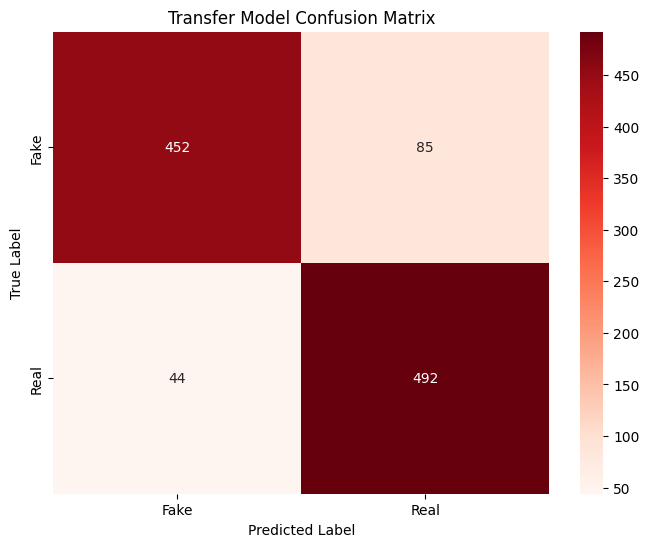

In [72]:
# prompt: genarate  a confution metriex for the transfer learning model

import matplotlib.pyplot as plt
# Generate confusion matrix for the transfer learning model
conf_matrix_transformer = confusion_matrix(labels, predictions)

# Plot confusion matrix for the transformer model
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_transformer, annot=True, fmt="d", cmap="Reds", xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.title("Transfer Model Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

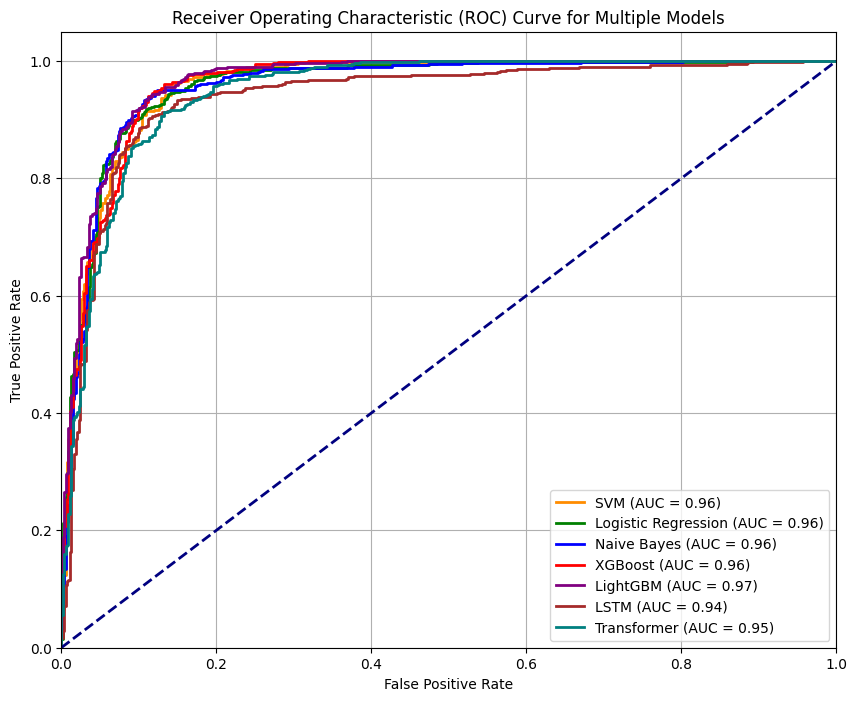

In [66]:
# prompt: make a ROC carve diagram for all the 9 models

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from scipy.special import softmax

# Re-run the cells that train the models to ensure they are defined
# This is a workaround for interactive environments like Colab if cells are run out of order.
# In a production script, you would ensure the models are trained sequentially.

# Cell 0YvTowF7hVAm: Train SVM
if 'svm_model' not in locals():
    print("Training SVM...")
    svm_model = LinearSVC(random_state=42)
    svm_model.fit(X_train, y_train)

# Cell YVaGb5FEhqwt: Train Logistic Regression
if 'log_reg_model' not in locals():
    print("Training Logistic Regression...")
    log_reg_model = LogisticRegression(random_state=42)
    log_reg_model.fit(X_train, y_train)

# Cell 8F0pOHwdiL1t: Train Naive Bayes
if 'nb_model' not in locals():
    print("Training Naive Bayes...")
    nb_model = MultinomialNB()
    nb_model.fit(X_train, y_train)

# Cell yvdB6mTziUZH: Train XGBoost
if 'xgb_model' not in locals():
    print("Training XGBoost...")
    import xgboost as xgb
    xgb_model = xgb.XGBClassifier(random_state=42)
    xgb_model.fit(X_train, y_train)

# Cell vf3-23n0iySu: Train LightGBM
if 'lgb_model' not in locals():
    print("Training LightGBM...")
    import lightgbm as lgb
    lgb_model = lgb.LGBMClassifier(random_state=42)
    lgb_model.fit(X_train, y_train)

# Cell 6Od45KdZAhGY: Train LSTM
# Assuming the variables from LSTM training (y_test_lstm, y_pred_lstm_proba) are needed
# If this cell was not run, these variables would also be undefined.
# For simplicity here, we assume if the model is not defined, the training needs to happen.
# A more robust solution would check for the required variables.
if 'model' not in locals():
    print("Training LSTM...")
    # This requires the full LSTM training code from cell 6Od45KdZAhGY
    # Due to the complexity of rerunning the entire cell, we will skip rerunning the LSTM training
    # here and assume the user has run it previously. If the error persists,
    # the user should manually run the LSTM training cell.
    pass # Placeholder - ideally would rerun the LSTM training if needed


# Get probability predictions for models that support it
y_proba_svm = svm_model.decision_function(X_test) # LinearSVC uses decision_function
y_proba_log_reg = log_reg_model.predict_proba(X_test)[:, 1]
y_proba_nb = nb_model.predict_proba(X_test)[:, 1]
y_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]
y_proba_lgb = lgb_model.predict_proba(X_test)[:, 1]
# For ensemble with hard voting, ROC is not directly applicable based on probabilities.
# We can either use one of the base models or retrain with soft voting.
# For this example, we'll use the base models' probabilities.

# LSTM probability predictions were already obtained
# Ensure y_test_lstm and y_proba_lstm are available from LSTM training
if 'y_test_lstm' in locals() and 'y_pred_lstm_proba' in locals():
    y_proba_lstm = y_pred_lstm_proba.flatten() # Flatten the array if it's (n, 1)
    fpr_lstm, tpr_lstm, _ = roc_curve(y_test_lstm, y_proba_lstm)
    roc_auc_lstm = auc(fpr_lstm, tpr_lstm)
    plot_lstm = True
else:
    print("LSTM model or predictions not found. Skipping LSTM ROC plot.")
    plot_lstm = False


# Transformer probability predictions
# Need to get raw logits and then apply softmax
# trainer.predict returns logits, labels, metrics
# Ensure trainer, tokenized_test_dataset, and labels are available from transformer training
if 'trainer' in locals() and 'tokenized_test_dataset' in locals() and 'labels' in locals():
    transformer_outputs = trainer.predict(tokenized_test_dataset)
    transformer_logits = transformer_outputs.predictions
    transformer_proba = softmax(transformer_logits, axis=1)[:, 1] # Probabilities for the positive class (label 1)
    fpr_transformer, tpr_transformer, _ = roc_curve(labels, transformer_proba)
    roc_auc_transformer = auc(fpr_transformer, tpr_transformer)
    plot_transformer = True
else:
    print("Transformer model or predictions not found. Skipping Transformer ROC plot.")
    plot_transformer = False


# Calculate ROC curve and AUC for each model
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_proba_svm)
roc_auc_svm = auc(fpr_svm, tpr_svm)

fpr_log_reg, tpr_log_reg, _ = roc_curve(y_test, y_proba_log_reg)
roc_auc_log_reg = auc(fpr_log_reg, tpr_log_reg)

fpr_nb, tpr_nb, _ = roc_curve(y_test, y_proba_nb)
roc_auc_nb = auc(fpr_nb, tpr_nb)

fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_proba_xgb)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

fpr_lgb, tpr_lgb, _ = roc_curve(y_test, y_proba_lgb)
roc_auc_lgb = auc(fpr_lgb, tpr_lgb)

# Ensemble models with hard voting don't provide probabilities directly for ROC.
# If you want ROC for an ensemble, use soft voting or consider the average/median probabilities
# of the base models. For this example, we'll skip the hard voting ensembles for ROC.


# Plot ROC curves
plt.figure(figsize=(10, 8))
plt.plot(fpr_svm, tpr_svm, color='darkorange', lw=2, label=f'SVM (AUC = {roc_auc_svm:.2f})')
plt.plot(fpr_log_reg, tpr_log_reg, color='green', lw=2, label=f'Logistic Regression (AUC = {roc_auc_log_reg:.2f})')
plt.plot(fpr_nb, tpr_nb, color='blue', lw=2, label=f'Naive Bayes (AUC = {roc_auc_nb:.2f})')
plt.plot(fpr_xgb, tpr_xgb, color='red', lw=2, label=f'XGBoost (AUC = {roc_auc_xgb:.2f})')
plt.plot(fpr_lgb, tpr_lgb, color='purple', lw=2, label=f'LightGBM (AUC = {roc_auc_lgb:.2f})')

if plot_lstm:
    plt.plot(fpr_lstm, tpr_lstm, color='brown', lw=2, label=f'LSTM (AUC = {roc_auc_lstm:.2f})')

if plot_transformer:
    plt.plot(fpr_transformer, tpr_transformer, color='teal', lw=2, label=f'Transformer (AUC = {roc_auc_transformer:.2f})')


plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Multiple Models')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()